In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [5]:
from scipy.optimize import curve_fit
from collections import namedtuple

In [6]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [7]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [8]:
from pymono.cnn_plots import plot_images2

In [9]:
#from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [51]:
from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset

In [54]:
from pymono.cnn_plots import plot2c_z, plot_images_and_labels, plot_images_and_positions

In [10]:
from pymono.cnn_eval import evaluate_cnn, evaluate_2c_cnn, cnn_xeval, single_run, train_cnn

In [11]:
from pymono.cnn_func import ResNet10

In [12]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [13]:
from pymono.cnn_func import CNN_basic

In [14]:
from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [15]:
from pymono.xdataset import PDataset

In [16]:
from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata

In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [18]:
data_dir = Path(os.environ['MONOLITH_DATA'])
crystal = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX")

In [19]:
crystal

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX'

# CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX

- CsI crystal assumed cold (100 k hot/MeV)

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 50 k photons per point (BGO, with ~9 k photons/MeV)
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation
- old data format (x,y,z)

### CNN comparisons: 
- Compare basic, 3x3 and resnet

## Setup

In [20]:
files_list_npy_csv(crystal)

('images',
 'metadata',
 array([  1,   2,   3,   4,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100]))

In [21]:
imgs, mdata = select_image_and_lbl(crystal, 3)

Selected files: img = images_4.npy, metdata = metadata_4.csv


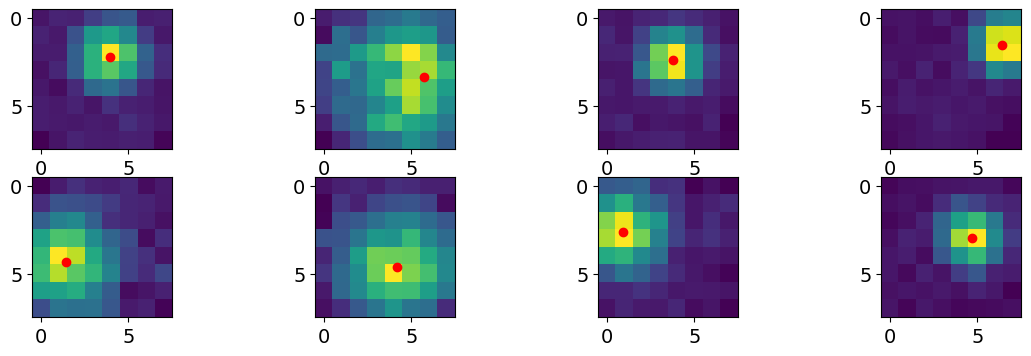

In [22]:
plot_images(imgs, mdata, range(0,8))

In [23]:
imgs[0]

array([[104., 123., 120., 160., 193., 202., 115., 118.],
       [122., 110., 188., 314., 335., 282., 156., 108.],
       [112., 112., 213., 356., 511., 390., 216., 136.],
       [ 99., 126., 211., 355., 401., 339., 199., 131.],
       [107.,  95., 131., 228., 244., 195., 127., 102.],
       [115., 110., 122., 104., 142., 119., 115., 104.],
       [114., 111., 107., 112., 110., 138., 122., 108.],
       [ 80., 104., 123., 114., 113., 118., 116.,  86.]], dtype=float32)

In [24]:
energy = get_energy(crystal, 9)

Selected files: img = images_25.npy, metdata = metadata_25.csv


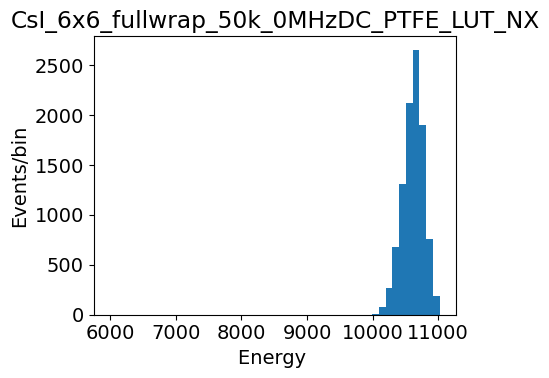

In [25]:
plot_energies2({"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX":energy}, xmin=6000, xmax=max(energy),num_bins = 50)

In [26]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 10616.38 sigma = 1.51 % FWHM = 3.47 %


## Short run
- Use a fraction (1/3) of data set.
- No normalization

In [27]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 200  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [28]:
# xyze = True for new data sets where the csv includes (x,y,z,nphot) but the network 
# compares with xyz. For old data sets (x,y,z) or new data sets comparing with a net of
# x,y,z,e output, use xyze = False (or remove, it is the default). 

dataset = MonoDataset(crystal, first_file, last_file, xyze=False)  # No comparison with energy only xyz


Running MonoDataset with norm = False, resize=False, xyze=False
Loading files with indexes: [  1   2   3   4  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100]


In [29]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 840000 events
 train size = 588000
 val size = 168000
 test size = 84000
 train indices = range(0, 588000)
 val indices = range(588000, 756000)
 test indices = range(756000, 840000)
588000 training events (70.0%)
168000 validation events (20.0%)
84000 test events (10.0%)


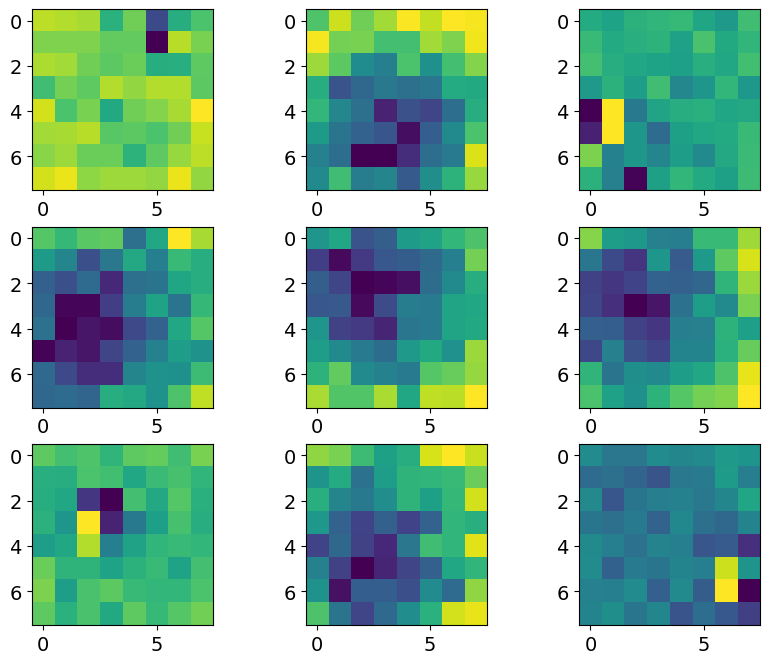

In [30]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [31]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([200, 1, 8, 8])
torch.Size([200, 3])
tensor([[201., 247., 294., 255., 190., 113., 103., 112.],
        [248., 353., 361., 278., 216., 152., 109., 103.],
        [259., 345., 380., 287., 209., 161., 143., 106.],
        [230., 295., 280., 256., 183., 144., 109., 120.],
        [190., 196., 192., 196., 164., 120., 120., 110.],
        [108., 131., 124., 148., 135., 132., 103., 112.],
        [119., 118., 121., 110.,  95., 125., 132., 108.],
        [101., 106., 107., 116., 125., 116., 121., 101.]])


In [32]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)

In [33]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [34]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->588000 images
size of train loader  ->2940 images
Evaluating with  ->168000 images
size of eval loader  ->840 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([200, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([200, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([200, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([200, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([200, 512])
torch.Size([200, 3])
--- EPOCH 0 AVG TRAIN LOSS: 6.728024826244432
--- EPOCH 0 AVG VAL LOSS: 4.716527962684632

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 4.6957558968440205
--- EPOCH 1 AVG VAL LOSS: 4.554724702380953

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 4.3329708837327505
--- EPOCH 2 AVG VAL LOSS: 4.124939283586683

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 4.147366551314892
--- EPOCH 3 AVG VAL LOSS: 4.027868839672633

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 4.025541640949898
--- EPOCH 4 AVG VAL LOSS: 3.9080271275270553

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 3.938190104685673
--- EPOCH 5 AVG 

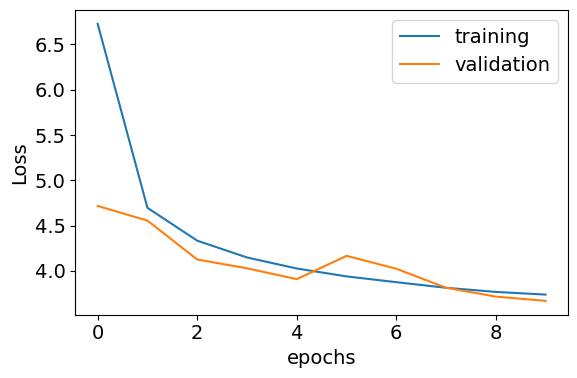

In [35]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [36]:
tdeltas = evaluate_cnn(test_loader, model, device)

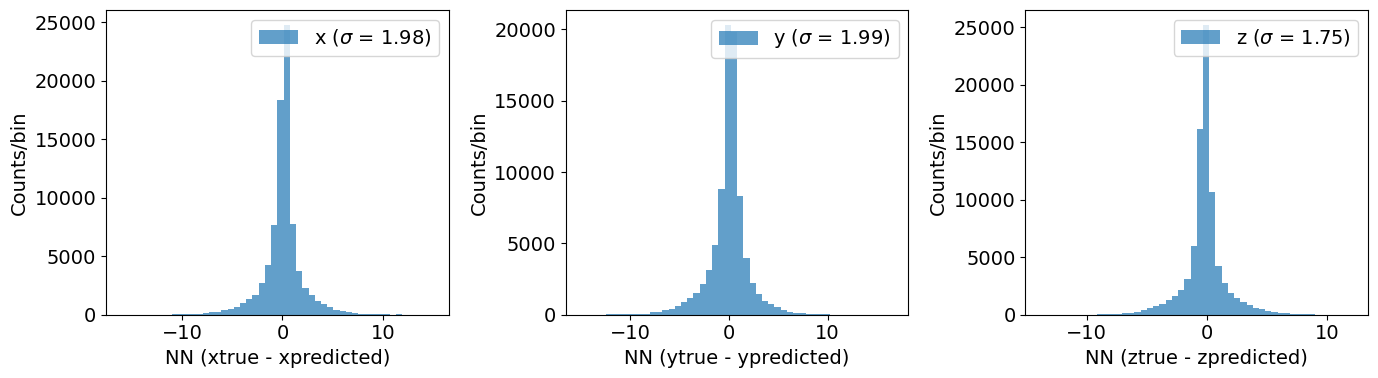

In [37]:
plotxyz(tdeltas, nbins=50)

In [38]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = -0.15, sigma = 0.39, n1  =0.84
2g fit: mu2 = -0.19, sigma = 1.94, n1  =0.16
weighted error: = 0.63
2g fit: mu1 = -0.02, sigma = 1.65, n1  =0.23
2g fit: mu2 = 0.22, sigma = 0.35, n1  =0.77
weighted error: = 0.65
2g fit: mu1 = -0.02, sigma = 1.90, n1  =0.25
2g fit: mu2 = 0.21, sigma = 0.46, n1  =0.75
weighted error: = 0.82


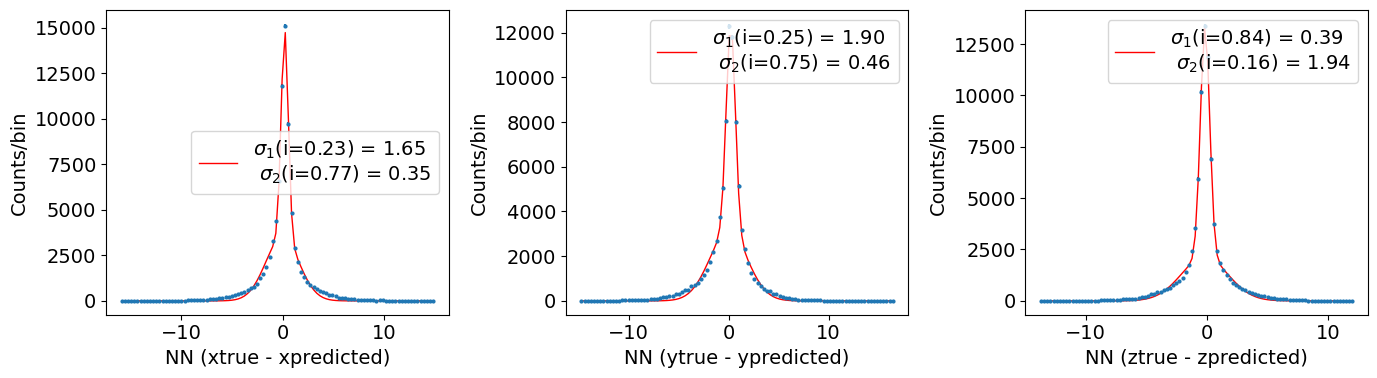

In [39]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

### Photoelectric data

In [40]:
dphe = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe")

img_names, csv_name = get_file_names_format1(dphe)
print(f"Directory with photoelectric image files = {dphe}")
print(f"name of first image file = {img_names[0]}")
print(f"name of label file ={csv_name}")

Directory with photoelectric image files = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe
name of first image file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_1.npy
name of label file =['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/phe.csv']


In [41]:
df1c = pd.read_csv(csv_name[0])
df1c.head(10)

,event_id,particle_id,particle_name,x,y,z,initial_t,kin_energy,creator_proc
0,10004,2,e-,18.645067,12.477487,29.249544,0.116340,0.477824,phot
1,10006,2,e-,13.566376,1.647984,21.156849,0.090734,0.475013,phot
2,10014,2,e-,-5.014233,5.060986,12.715019,0.062352,0.509922,phot
3,10024,2,e-,-3.514938,-0.639491,15.746504,0.074194,0.475013,phot
4,10026,2,e-,18.973616,-6.031100,16.421364,0.074508,0.475013,phot
5,10027,2,e-,11.437413,-22.155209,40.912632,0.157729,0.505283,phot
6,10028,2,e-,9.708068,3.101630,13.316263,0.064982,0.477824,phot
7,10029,2,e-,0.335767,-11.193620,21.898740,0.093051,0.475013,phot
8,10030,2,e-,16.716444,15.401320,25.922293,0.107143,0.475013,phot
9,10031,2,e-,14.411372,14.232203,48.868683,0.182639,0.475013,phot


In [42]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")

image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 1762
number of labels in file = 1762


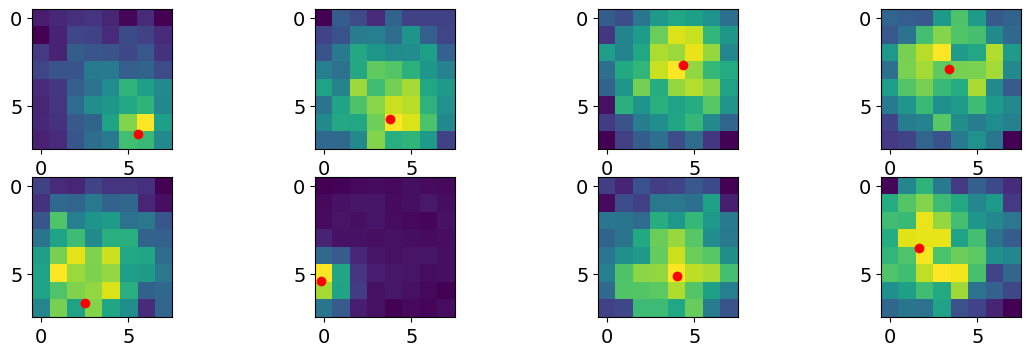

In [43]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [48]:
datasetpe = PDataset(dphe, first_file, last_file, norm=False)  

Running pDataset with norm = False
   event_id  particle_id particle_name          x          y          z  \
0     10004            2            e-  18.645067  12.477487  29.249544   
1     10006            2            e-  13.566376   1.647984  21.156849   
2     10014            2            e-  -5.014233   5.060986  12.715019   
3     10024            2            e-  -3.514938  -0.639491  15.746504   
4     10026            2            e-  18.973616  -6.031100  16.421364   
5     10027            2            e-  11.437413 -22.155209  40.912632   
6     10028            2            e-   9.708068   3.101630  13.316263   
7     10029            2            e-   0.335767 -11.193620  21.898740   
8     10030            2            e-  16.716444  15.401320  25.922293   
9     10031            2            e-  14.411372  14.232203  48.868683   

   initial_t  kin_energy creator_proc  
0   0.116340    0.477824         phot  
1   0.090734    0.475013         phot  
2   0.062352    0.5

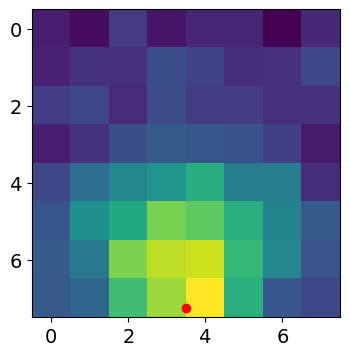

In [52]:
plot_dataset(datasetpe[15], pixel_size = 6, grid_size=8)

In [49]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(datasetpe, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 170299 events
 train size = 119209
 val size = 34059
 test size = 17031
 train indices = range(0, 119209)
 val indices = range(119209, 153268)
 test indices = range(153268, 170299)
119209 training events (69.99982383924744%)
34059 validation events (19.999530237993177%)
17031 test events (10.000645922759382%)


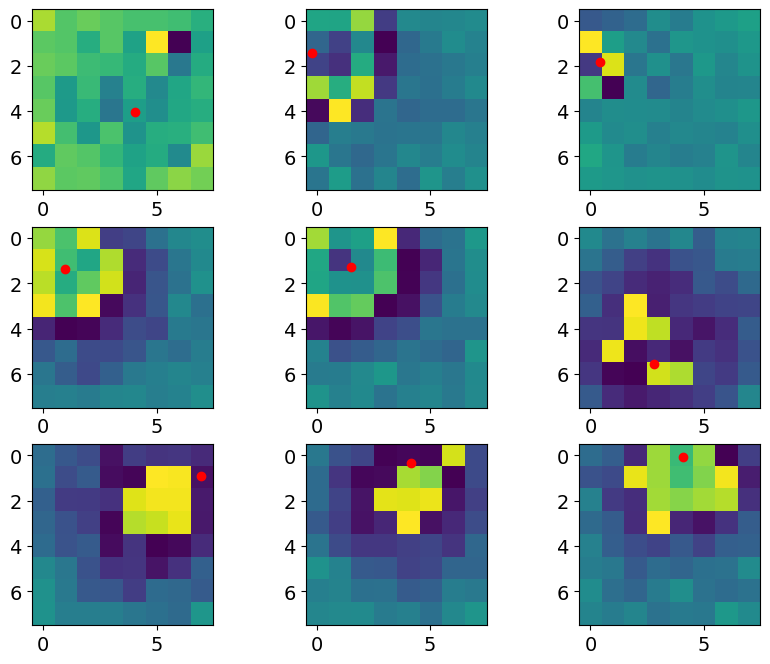

In [55]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

In [56]:
modelpe = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)
optimizer = optim.Adam(modelpe.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [57]:
train_losses, val_losses = train_cnn(train_loader, val_loader, modelpe, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->119400 images
size of train loader  ->597 images
Evaluating with  ->34200 images
size of eval loader  ->171 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([200, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([200, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([200, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([200, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([200, 512])
torch.Size([200, 3])
--- EPOCH 0 AVG TRAIN LOSS: 13.648036093368402
--- EPOCH 0 AVG VAL LOSS: 11.896332222118712

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.977328955428285
--- EPOCH 1 AVG VAL LOSS: 8.223478069082338

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.41271576569907
--- EPOCH 2 AVG VAL LOSS: 7.7011627035531385

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.997663096167534
--- EPOCH 3 AVG VAL LOSS: 8.754752967789857

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.732977505305304
--- EPOCH 4 AVG VAL LOSS: 8.10706283056248

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.584045861434298
--- EPOCH 5 AVG VAL 

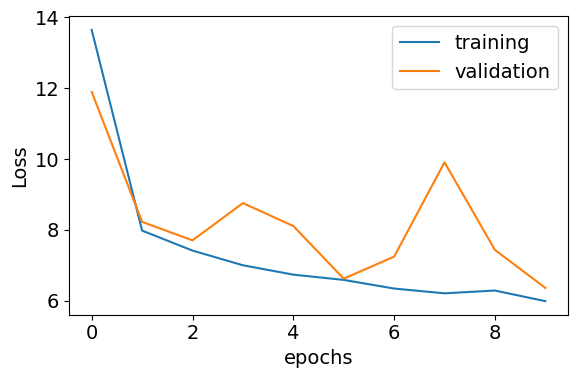

In [58]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [59]:
tdeltas = evaluate_cnn(train_loader, modelpe, device)

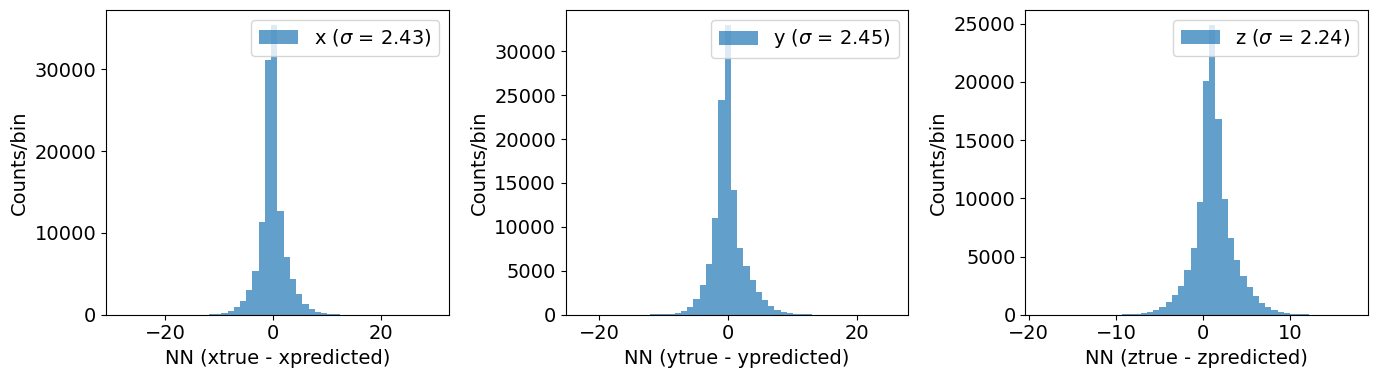

In [60]:
plotxyz(tdeltas, nbins=50)

In [61]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = 0.96, sigma = 0.70, n1  =0.68
2g fit: mu2 = 1.00, sigma = 2.55, n1  =0.32
weighted error: = 1.30
2g fit: mu1 = -0.23, sigma = 0.69, n1  =0.74
2g fit: mu2 = -0.04, sigma = 2.71, n1  =0.26
weighted error: = 1.22
2g fit: mu1 = -0.10, sigma = 2.71, n1  =0.29
2g fit: mu2 = -0.36, sigma = 0.65, n1  =0.71
weighted error: = 1.24


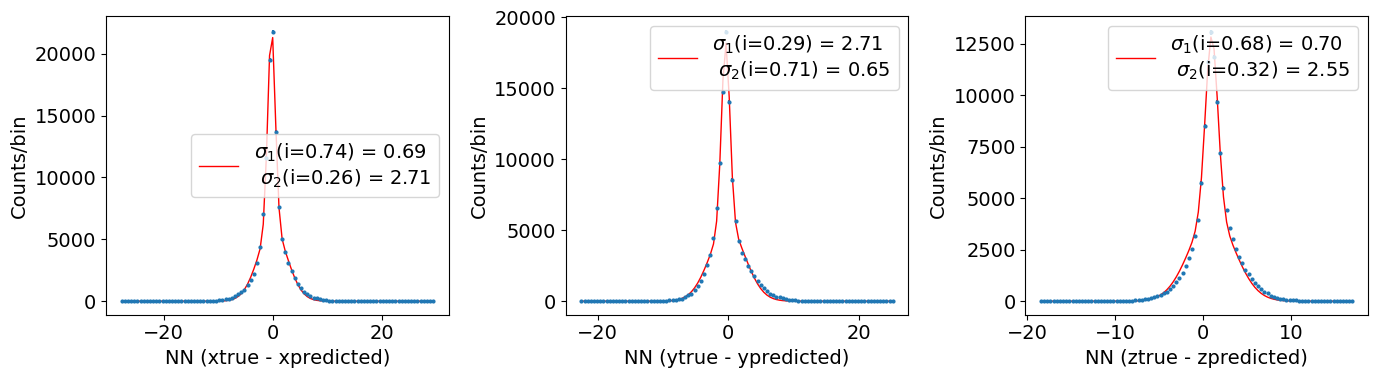

In [62]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))